# Laboratório de Classificação de Dígitos com PyTorch

Neste laboratório, vamos explorar a construção, treinamento e avaliação de uma rede neural convolucional (CNN) para a tarefa de classificação de dígitos utilizando o dataset MNIST. O MNIST é um conjunto de dados amplamente utilizado na área de aprendizado de máquina e visão computacional, composto por imagens de dígitos manuscritos de 0 a 9.

## Objetivos

1. **Preparação do Ambiente**: Configurar o ambiente de desenvolvimento e verificar a disponibilidade de GPU.
2. **Pré-processamento dos Dados**: Baixar o dataset MNIST, calcular a média e o desvio padrão das imagens, e aplicar transformações necessárias.
3. **Visualização dos Dados**: Visualizar algumas imagens do dataset para entender melhor os dados com os quais estamos trabalhando.
4. **Construção do Modelo**: Definir a arquitetura da rede neural convolucional.
5. **Treinamento do Modelo**: Treinar a CNN utilizando o conjunto de treinamento e validar seu desempenho.
6. **Avaliação do Modelo**: Avaliar o modelo treinado utilizando métricas de desempenho e visualizar a matriz de confusão.
7. **Análise de Erros**: Identificar e visualizar exemplos de erros de classificação para entender melhor as limitações do modelo.

## Ferramentas Utilizadas

- **PyTorch**: Biblioteca de aprendizado de máquina para construção e treinamento de modelos.
- **Torchvision**: Biblioteca que fornece datasets, modelos pré-treinados e transformações comuns para visão computacional.
- **Matplotlib e Seaborn**: Bibliotecas para visualização de dados.
- **Scikit-learn**: Biblioteca para métricas de avaliação.

Vamos começar configurando o ambiente e verificando a disponibilidade de GPU.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

In [2]:
# Verifica se uma GPU está disponível e, se estiver, usa a GPU; caso contrário, usa a CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Imprime o dispositivo que será utilizado (GPU ou CPU)
print("Dispositivo:", device)

Dispositivo: cuda


In [3]:
# Baixa o dataset MNIST sem transformações além de converter para tensor
raw_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Concatena todas as imagens do dataset em um único tensor
all_data = torch.cat([data[0] for data in raw_dataset])

# Calcula a média de todos os pixels das imagens
mean = all_data.mean()

# Calcula o desvio padrão de todos os pixels das imagens
std = all_data.std()

# Imprime a média e o desvio padrão calculados
print(f"Média: {mean.item():.4f}")
print(f"Desvio padrão: {std.item():.4f}")

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 504kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.79MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 12.6MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Média: 0.1307
Desvio padrão: 0.3081


In [4]:
# Define uma sequência de transformações a serem aplicadas nas imagens
transform = transforms.Compose([
    transforms.ToTensor(),  # Converte as imagens para tensores
    transforms.Normalize((mean,), (std,))  # Normaliza as imagens usando a média e o desvio padrão calculados
])

# Baixa o dataset MNIST e aplica as transformações definidas
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Define o tamanho do conjunto de treino (90% do total)
train_size = int(0.9 * len(dataset))
# Define o tamanho do conjunto de validação (10% do total)
val_size = len(dataset) - train_size
# Divide o dataset em conjuntos de treino e validação
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define o tamanho do batch
batch_size = 64
# Cria um DataLoader para o conjunto de treino com embaralhamento
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Cria um DataLoader para o conjunto de validação sem embaralhamento
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Imprime o número total de imagens para treino
print("Número total de imagens para treino:", len(train_dataset))
# Imprime o número total de imagens para validação
print("Número total de imagens para validação:", len(val_dataset))

Número total de imagens para treino: 54000
Número total de imagens para validação: 6000


## Visualização de Imagens do Dataset

Nesta célula, vamos visualizar algumas imagens do dataset de treino para entender melhor os dados com os quais estamos trabalhando. Vamos selecionar um número específico de imagens para cada classe (dígitos de 0 a 9) e exibi-las em uma grade.

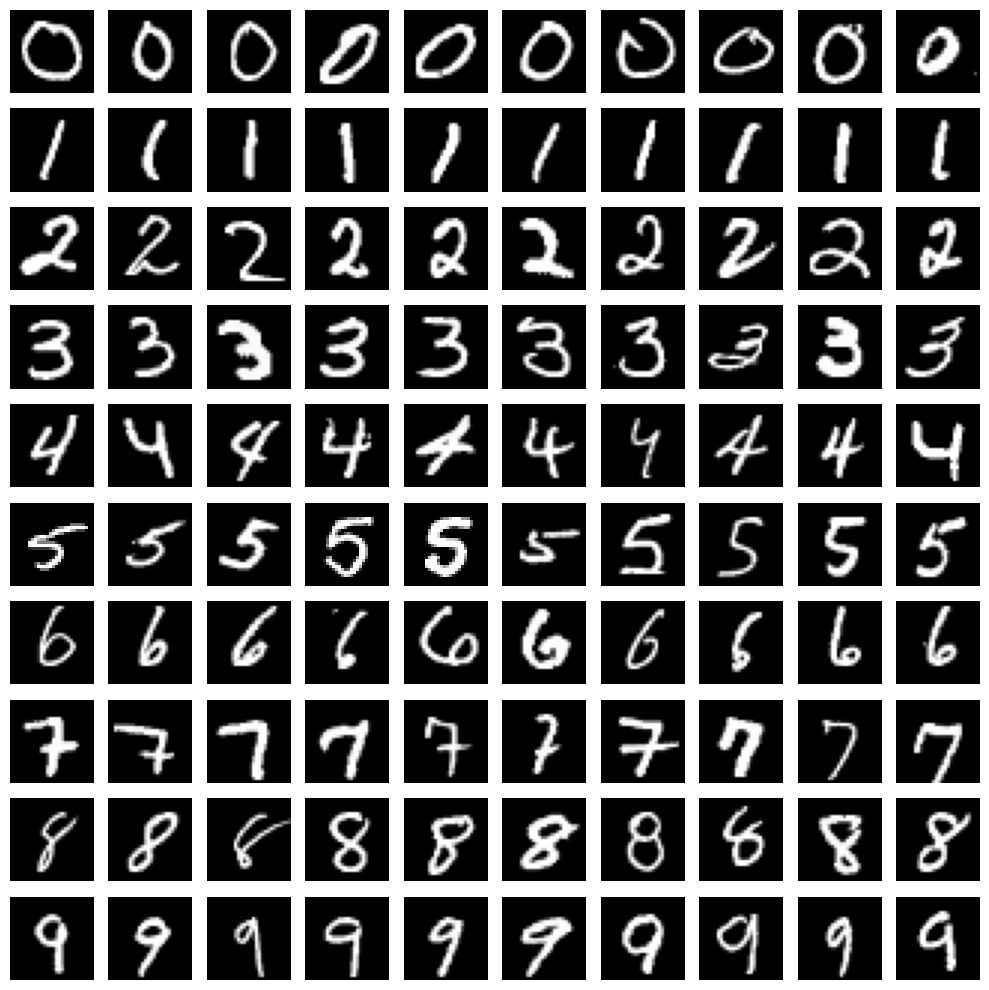

In [5]:
# Define o número de classes (dígitos de 0 a 9)
num_classes = 10
# Define o número de imagens por classe que queremos visualizar
images_per_class = 10
# Cria um dicionário para armazenar as imagens de cada classe
class_images = {i: [] for i in range(num_classes)}

# Itera sobre o DataLoader de treino para coletar as imagens
for images, labels in train_loader:
    for img, label in zip(images, labels):
        # Adiciona a imagem à lista da classe correspondente se ainda não atingiu o limite
        if len(class_images[label.item()]) < images_per_class:
            class_images[label.item()].append(img)
    # Verifica se já coletamos o número necessário de imagens para todas as classes
    if all(len(imgs) == images_per_class for imgs in class_images.values()):
        break

# Cria uma figura com subplots para visualizar as imagens
fig, axes = plt.subplots(num_classes, images_per_class, figsize=(images_per_class, num_classes))

# Itera sobre cada classe e suas imagens
for class_idx, images in class_images.items():
    for img_idx, img in enumerate(images):
        ax = axes[class_idx, img_idx]
        # Remove a dimensão do canal da imagem
        img = img.squeeze(0)
        # Exibe a imagem no subplot correspondente
        ax.imshow(img, cmap="gray")
        # Remove os eixos para uma visualização mais limpa
        ax.axis("off")

# Ajusta o layout para evitar sobreposição
plt.tight_layout()
# Exibe a figura
plt.show()

## Construção do Modelo

Nesta célula, vamos definir a arquitetura da rede neural convolucional (CNN) que será utilizada para a classificação dos dígitos do dataset MNIST. A CNN será composta por camadas convolucionais, camadas de pooling e camadas totalmente conectadas.

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Primeira camada convolucional: 1 canal de entrada (imagem em escala de cinza), 32 filtros, kernel 3x3, padding 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        # Segunda camada convolucional: 32 canais de entrada, 64 filtros, kernel 3x3, padding 1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Camada de pooling: reduz a dimensionalidade pela metade usando max pooling 2x2
        self.pool = nn.MaxPool2d(2, 2)
        # Primeira camada totalmente conectada: entrada de 64 * 7 * 7 (tamanho da imagem após convoluções e pooling), 128 neurônios
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        # Segunda camada totalmente conectada: 128 neurônios de entrada, 10 neurônios de saída (10 classes)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Aplica a primeira camada convolucional seguida de ReLU
        x = torch.relu(self.conv1(x))
        # Aplica a camada de pooling
        x = self.pool(x)
        # Aplica a segunda camada convolucional seguida de ReLU
        x = torch.relu(self.conv2(x))
        # Aplica a camada de pooling novamente
        x = self.pool(x)
        # Achata o tensor para que possa ser passado para a camada totalmente conectada
        x = x.view(-1, 64 * 7 * 7)
        # Aplica a primeira camada totalmente conectada seguida de ReLU
        x = torch.relu(self.fc1(x))
        # Aplica a segunda camada totalmente conectada (saída)
        x = self.fc2(x)
        return x

In [7]:
# Instancia o modelo CNN definido anteriormente e move-o para o dispositivo (GPU ou CPU)
model = CNN().to(device)

# Exibe um resumo da arquitetura do modelo, incluindo o tamanho das entradas e saídas de cada camada
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Linear-5                  [-1, 128]         401,536
            Linear-6                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.36
Params size (MB): 1.61
Estimated Total Size (MB): 1.97
----------------------------------------------------------------


## Treinamento e Avaliação do Modelo

Nesta célula, vamos realizar o treinamento e a avaliação do modelo CNN definido anteriormente. O processo será dividido nas seguintes etapas:

1. **Definição de Funções de Treinamento e Avaliação**: Funções para treinar o modelo por uma época e para avaliar o modelo no conjunto de validação.
2. **Configuração de Hiperparâmetros**: Definição do número de épocas, função de perda e otimizador.
3. **Loop de Treinamento**: Loop principal que executa o treinamento e a avaliação do modelo por várias épocas, armazenando as métricas de desempenho.
4. **Salvamento do Melhor Modelo**: Salvamento do estado do modelo com a melhor acurácia de validação.

Ao final desta célula, teremos um modelo treinado e avaliado, com as métricas de desempenho registradas para análise posterior.

In [8]:
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()  # Coloca o modelo em modo de treinamento
    running_loss = 0.0  # Inicializa a perda acumulada
    correct = 0  # Inicializa o contador de acertos
    total_samples = 0  # Inicializa o contador de amostras
    loop = tqdm(dataloader, desc="Treinando", leave=False)  # Cria um loop de progresso para o DataLoader

    for inputs, targets in loop:  # Itera sobre o DataLoader
        inputs, targets = inputs.to(device), targets.to(device)  # Move os dados para o dispositivo (GPU ou CPU)
        optimizer.zero_grad()  # Zera os gradientes do otimizador
        outputs = model(inputs)  # Faz a previsão do modelo
        loss = criterion(outputs, targets)  # Calcula a perda
        loss.backward()  # Calcula os gradientes
        optimizer.step()  # Atualiza os pesos do modelo

        running_loss += loss.item() * inputs.size(0)  # Acumula a perda
        _, preds = torch.max(outputs, 1)  # Obtém as previsões
        correct += torch.sum(preds == targets).item()  # Conta os acertos
        total_samples += targets.size(0)  # Conta o total de amostras

        loop.set_postfix(loss=loss.item())  # Atualiza o loop de progresso com a perda atual

    epoch_loss = running_loss / len(dataloader.dataset)  # Calcula a perda média por época
    epoch_acc = correct / total_samples  # Calcula a acurácia por época
    return epoch_loss, epoch_acc  # Retorna a perda e a acurácia da época

def evaluate(model, dataloader, criterion):
    model.eval()  # Coloca o modelo em modo de avaliação
    running_loss = 0.0  # Inicializa a perda acumulada
    correct = 0  # Inicializa o contador de acertos
    total_samples = 0  # Inicializa o contador de amostras
    loop = tqdm(dataloader, desc="Avaliando", leave=True)  # Cria um loop de progresso para o DataLoader

    with torch.no_grad():  # Desabilita o cálculo de gradientes
        for inputs, targets in loop:  # Itera sobre o DataLoader
            inputs, targets = inputs.to(device), targets.to(device)  # Move os dados para o dispositivo (GPU ou CPU)
            outputs = model(inputs)  # Faz a previsão do modelo
            loss = criterion(outputs, targets)  # Calcula a perda
            running_loss += loss.item() * inputs.size(0)  # Acumula a perda

            _, preds = torch.max(outputs, 1)  # Obtém as previsões
            correct += torch.sum(preds == targets).item()  # Conta os acertos
            total_samples += targets.size(0)  # Conta o total de amostras
            loop.set_postfix(loss=loss.item())  # Atualiza o loop de progresso com a perda atual

    epoch_loss = running_loss / len(dataloader.dataset)  # Calcula a perda média por época
    epoch_acc = correct / total_samples  # Calcula a acurácia por época
    return epoch_loss, epoch_acc  # Retorna a perda e a acurácia da época

num_epochs = 10  # Define o número de épocas
criterion = nn.CrossEntropyLoss()  # Define a função de perda
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Define o otimizador

train_losses = []  # Lista para armazenar as perdas de treino
val_losses = []  # Lista para armazenar as perdas de validação
train_accuracies = []  # Lista para armazenar as acurácias de treino
val_accuracies = []  # Lista para armazenar as acurácias de validação

best_val_acc = 0.0  # Inicializa a melhor acurácia de validação
best_model_path = "best_model.pth"  # Caminho para salvar o melhor modelo

for epoch in range(num_epochs):  # Loop sobre o número de épocas
    print(f"Época {epoch+1}/{num_epochs}")  # Imprime a época atual

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)  # Treina o modelo e obtém a perda e acurácia de treino
    val_loss, val_acc = evaluate(model, val_loader, criterion)  # Avalia o modelo e obtém a perda e acurácia de validação

    train_losses.append(train_loss)  # Armazena a perda de treino
    val_losses.append(val_loss)  # Armazena a perda de validação
    train_accuracies.append(train_acc)  # Armazena a acurácia de treino
    val_accuracies.append(val_acc)  # Armazena a acurácia de validação

    print(f"Loss Treino: {train_loss:.4f} | Acurácia Treino: {train_acc*100:.2f}% | Loss Validação: {val_loss:.4f} | Acurácia Validação: {val_acc*100:.2f}%")  # Imprime as métricas da época

    if val_acc > best_val_acc:  # Verifica se a acurácia de validação atual é a melhor
        best_val_acc = val_acc  # Atualiza a melhor acurácia de validação
        torch.save(model.state_dict(), best_model_path)  # Salva o estado do modelo
        print(f"Modelo salvo com acurácia de {val_acc*100:.2f}%")  # Imprime mensagem de modelo salvo


Época 1/10


Avaliando: 100%|██████████| 94/94 [00:03<00:00, 25.61it/s, loss=0.0111]


Loss Treino: 0.1452 | Acurácia Treino: 95.56% | Loss Validação: 0.0671 | Acurácia Validação: 98.02%
Modelo salvo com acurácia de 98.02%
Época 2/10


Avaliando: 100%|██████████| 94/94 [00:01<00:00, 55.42it/s, loss=0.00408]


Loss Treino: 0.0451 | Acurácia Treino: 98.65% | Loss Validação: 0.0547 | Acurácia Validação: 98.13%
Modelo salvo com acurácia de 98.13%
Época 3/10


Avaliando: 100%|██████████| 94/94 [00:01<00:00, 59.73it/s, loss=0.000825]


Loss Treino: 0.0316 | Acurácia Treino: 98.95% | Loss Validação: 0.0378 | Acurácia Validação: 98.88%
Modelo salvo com acurácia de 98.88%
Época 4/10


Avaliando: 100%|██████████| 94/94 [00:01<00:00, 61.31it/s, loss=0.00907]


Loss Treino: 0.0219 | Acurácia Treino: 99.31% | Loss Validação: 0.0460 | Acurácia Validação: 98.60%
Época 5/10


Avaliando: 100%|██████████| 94/94 [00:01<00:00, 61.01it/s, loss=0.00239]


Loss Treino: 0.0173 | Acurácia Treino: 99.43% | Loss Validação: 0.0420 | Acurácia Validação: 98.70%
Época 6/10


Avaliando: 100%|██████████| 94/94 [00:01<00:00, 66.16it/s, loss=0.000407]


Loss Treino: 0.0142 | Acurácia Treino: 99.53% | Loss Validação: 0.0334 | Acurácia Validação: 99.12%
Modelo salvo com acurácia de 99.12%
Época 7/10


Avaliando: 100%|██████████| 94/94 [00:01<00:00, 54.87it/s, loss=0.000187]


Loss Treino: 0.0097 | Acurácia Treino: 99.69% | Loss Validação: 0.0340 | Acurácia Validação: 99.05%
Época 8/10


Avaliando: 100%|██████████| 94/94 [00:01<00:00, 63.89it/s, loss=0.000203]


Loss Treino: 0.0097 | Acurácia Treino: 99.68% | Loss Validação: 0.0426 | Acurácia Validação: 98.95%
Época 9/10


Avaliando: 100%|██████████| 94/94 [00:01<00:00, 53.90it/s, loss=0.000169]


Loss Treino: 0.0075 | Acurácia Treino: 99.76% | Loss Validação: 0.0539 | Acurácia Validação: 98.88%
Época 10/10


Avaliando: 100%|██████████| 94/94 [00:01<00:00, 67.71it/s, loss=1.85e-6]

Loss Treino: 0.0062 | Acurácia Treino: 99.80% | Loss Validação: 0.0580 | Acurácia Validação: 98.82%


## Métricas de Avaliação

Nesta seção, vamos visualizar as métricas de desempenho do modelo treinado. As métricas incluem a curva de loss e acurácia ao longo das épocas de treinamento e validação. Além disso, vamos carregar o melhor modelo salvo durante o treinamento e avaliar seu desempenho no conjunto de validação, gerando a matriz de confusão e o relatório de classificação. Também vamos visualizar alguns exemplos de erros de classificação para entender melhor as limitações do modelo.

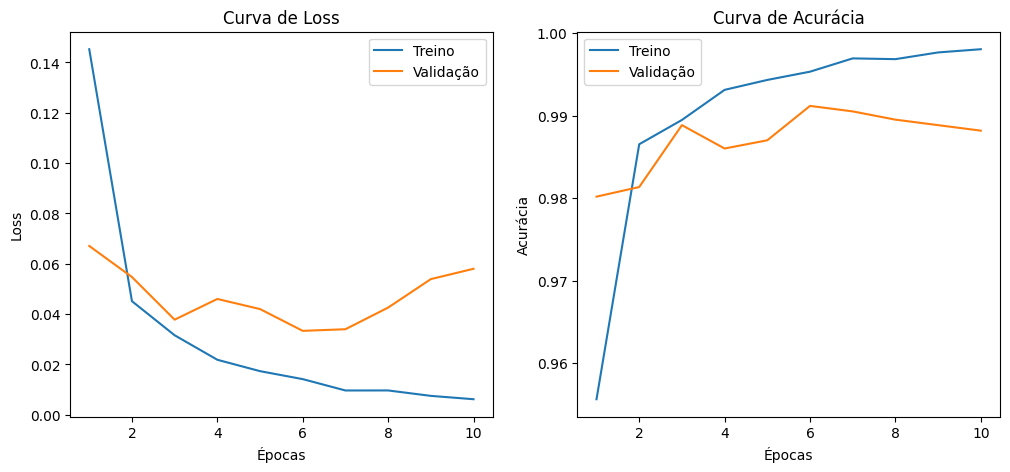

In [9]:
# Cria uma nova figura com tamanho especificado
plt.figure(figsize=(12, 5))

# Adiciona um subplot na posição 1 (1 linha, 2 colunas, 1º subplot)
plt.subplot(1, 2, 1)
# Plota a curva de loss de treino ao longo das épocas
plt.plot(range(1, num_epochs + 1), train_losses, label="Treino")
# Plota a curva de loss de validação ao longo das épocas
plt.plot(range(1, num_epochs + 1), val_losses, label="Validação")
# Define o rótulo do eixo x
plt.xlabel("Épocas")
# Define o rótulo do eixo y
plt.ylabel("Loss")
# Define o título do gráfico
plt.title("Curva de Loss")
# Adiciona uma legenda ao gráfico
plt.legend()

# Adiciona um subplot na posição 2 (1 linha, 2 colunas, 2º subplot)
plt.subplot(1, 2, 2)
# Plota a curva de acurácia de treino ao longo das épocas
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Treino")
# Plota a curva de acurácia de validação ao longo das épocas
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validação")
# Define o rótulo do eixo x
plt.xlabel("Épocas")
# Define o rótulo do eixo y
plt.ylabel("Acurácia")
# Define o título do gráfico
plt.title("Curva de Acurácia")
# Adiciona uma legenda ao gráfico
plt.legend()

# Exibe a figura com os subplots
plt.show()

<ipython-input-10-d9712d8f7441>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_model.pth"))


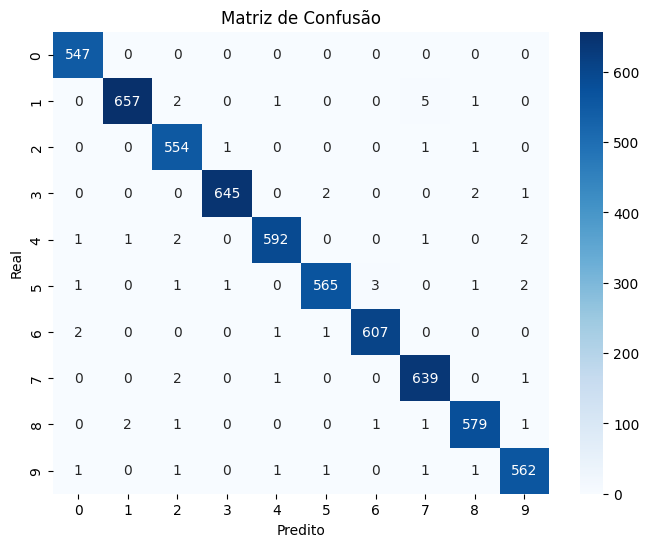


Relatório de Classificação:

              precision    recall  f1-score   support

           0     0.9909    1.0000    0.9955       547
           1     0.9955    0.9865    0.9910       666
           2     0.9840    0.9946    0.9893       557
           3     0.9969    0.9923    0.9946       650
           4     0.9933    0.9883    0.9908       599
           5     0.9930    0.9843    0.9886       574
           6     0.9935    0.9935    0.9935       611
           7     0.9861    0.9938    0.9899       643
           8     0.9897    0.9897    0.9897       585
           9     0.9877    0.9894    0.9886       568

    accuracy                         0.9912      6000
   macro avg     0.9911    0.9912    0.9911      6000
weighted avg     0.9912    0.9912    0.9912      6000



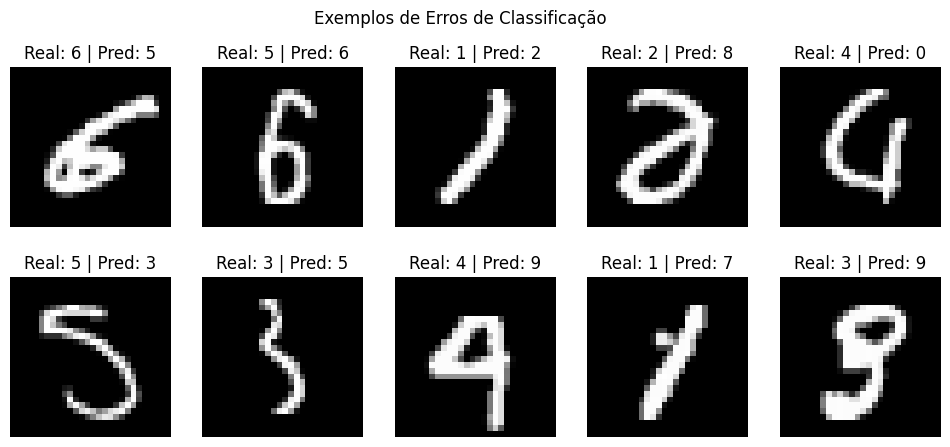

In [10]:
# Cria uma instância do modelo CNN e move-o para o dispositivo (GPU ou CPU)
best_model = CNN().to(device)
# Carrega os pesos do melhor modelo salvo durante o treinamento
best_model.load_state_dict(torch.load("best_model.pth"))
# Coloca o modelo em modo de avaliação
best_model.eval()

# Inicializa listas para armazenar os rótulos verdadeiros e previstos
true_labels = []
predicted_labels = []
# Inicializa uma lista para armazenar exemplos de classificações incorretas
misclassified_examples = []

# Desabilita o cálculo de gradientes
with torch.no_grad():
    # Itera sobre o DataLoader de validação
    for inputs, targets in val_loader:
        # Move os dados para o dispositivo (GPU ou CPU)
        inputs, targets = inputs.to(device), targets.to(device)
        # Faz a previsão do modelo
        outputs = best_model(inputs)
        # Obtém as previsões
        _, preds = torch.max(outputs, 1)

        # Adiciona os rótulos verdadeiros e previstos às listas
        true_labels.extend(targets.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

        # Armazena exemplos de classificações incorretas (até 10 exemplos)
        for img, true, pred in zip(inputs.cpu(), targets.cpu(), preds.cpu()):
            if true != pred and len(misclassified_examples) < 10:
                misclassified_examples.append((img, true, pred))

# Converte as listas de rótulos para arrays numpy
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calcula a matriz de confusão
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Cria uma figura para a matriz de confusão
plt.figure(figsize=(8, 6))
# Plota a matriz de confusão usando seaborn
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
# Define o rótulo do eixo x
plt.xlabel("Predito")
# Define o rótulo do eixo y
plt.ylabel("Real")
# Define o título do gráfico
plt.title("Matriz de Confusão")
# Exibe a figura
plt.show()

# Imprime o relatório de classificação
print("\nRelatório de Classificação:\n")
print(classification_report(true_labels, predicted_labels, digits=4))

# Cria uma figura com subplots para visualizar exemplos de classificações incorretas
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

# Itera sobre os exemplos de classificações incorretas
for i, (img, true, pred) in enumerate(misclassified_examples):
    # Seleciona o subplot correspondente
    ax = axes[i // 5, i % 5]
    # Remove a dimensão do canal da imagem e converte para numpy
    img = img.squeeze(0).numpy()
    # Exibe a imagem no subplot correspondente
    ax.imshow(img, cmap="gray")
    # Define o título do subplot com os rótulos verdadeiro e previsto
    ax.set_title(f"Real: {true} | Pred: {pred}")
    # Remove os eixos para uma visualização mais limpa
    ax.axis("off")

# Define o título da figura
plt.suptitle("Exemplos de Erros de Classificação")
# Exibe a figura
plt.show()